# KNN Simulations PCA avec réduction de dimensions

## Import des librairies

In [1]:
# !pip install geopandas
# !pip install --upgrade matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from datetime import datetime, timezone, timedelta
from sklearn.metrics import confusion_matrix, classification_report
# import geopandas
from sklearn.linear_model import LinearRegression, LogisticRegression

from scipy.stats import chi2_contingency

# Import des librairies bokeh
from bokeh.models import ColumnDataSource, GeoJSONDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import row,column
from bokeh.io import push_notebook,output_notebook, show
output_notebook()  # pour un affichage dans le notebook

Loading BokehJS ...

##Chargement du fichier avec les variables issues de la phase preprocessing

In [2]:
# df_final = pd.read_csv(path, index_col=0)
df_final = pd.read_csv("C:\workspaces\Datascientest\MonProjetMeteo\data\weatherAUS_Kapy_v2_20230708.csv",
                       index_col=0,parse_dates=[1])

In [3]:
# Affichage du nombre de valeurs restantes avec un dropna
df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    119115 non-null  datetime64[ns]
 1   Location                119115 non-null  object        
 2   Rainfall                119115 non-null  float64       
 3   WindGustSpeed           119115 non-null  float64       
 4   Temp9am                 119115 non-null  float64       
 5   RainTomorrow            119115 non-null  float64       
 6   DayOfYear               119115 non-null  int64         
 7   Month                   119115 non-null  int64         
 8   Latitude                119115 non-null  float64       
 9   Longitude               119115 non-null  float64       
 10  diffWind3pm9am          119115 non-null  float64       
 11  diffTempMinMax          119115 non-null  float64       
 12  diffPressure9am3pm      119115

##Suppression de quelques variables non utilisées

In [4]:
# suppression du lieu, et des coord géographiques
df = df_final.drop(['Date','Location','Latitude','Longitude'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   RainTomorrow            119115 non-null  float64
 4   DayOfYear               119115 non-null  int64  
 5   Month                   119115 non-null  int64  
 6   diffWind3pm9am          119115 non-null  float64
 7   diffTempMinMax          119115 non-null  float64
 8   diffPressure9am3pm      119115 non-null  float64
 9   Pressure                119115 non-null  float64
 10  DeltaP_1d               119115 non-null  float64
 11  DeltaP_2d               119115 non-null  float64
 12  DeltaP_3d               119115 non-null  float64
 13  diffHimidity9am3pm      119115 non-null  float64
 14  Humidity            

# Jeu de données d'entrainement et de test

In [5]:
# séparation en features et target
target = df["RainTomorrow"]
features = df.drop("RainTomorrow",axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119115 entries, 3 to 145458
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall                119115 non-null  float64
 1   WindGustSpeed           119115 non-null  float64
 2   Temp9am                 119115 non-null  float64
 3   DayOfYear               119115 non-null  int64  
 4   Month                   119115 non-null  int64  
 5   diffWind3pm9am          119115 non-null  float64
 6   diffTempMinMax          119115 non-null  float64
 7   diffPressure9am3pm      119115 non-null  float64
 8   Pressure                119115 non-null  float64
 9   DeltaP_1d               119115 non-null  float64
 10  DeltaP_2d               119115 non-null  float64
 11  DeltaP_3d               119115 non-null  float64
 12  diffHimidity9am3pm      119115 non-null  float64
 13  Humidity                119115 non-null  float64
 14  DeltaH_1d           

In [6]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import confusion_matrix

In [7]:
# séparation en jeux d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state = 42, shuffle = True)
print(X_train.shape)
print(X_test.shape)
print(pd.DataFrame(y_test).value_counts())

(95292, 28)
(23823, 28)
RainTomorrow
0.0             18590
1.0              5233
dtype: int64


# **Normalisation des données**

In [8]:
from sklearn.preprocessing import MinMaxScaler

# pour plus d'info, voir : https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(X_train,y_train)

X_test_minmax = minmax.transform(X_test)

pd.DataFrame(X_train_minmax).describe().transpose().mean()

count    95292.000000
mean         0.321393
std          0.171141
min          0.000000
25%          0.226067
50%          0.279766
75%          0.409257
max          1.000000
dtype: float64

In [9]:
def Accuracy(TP,TN,FP,FN):
    return (TP+TN)/(TP+FP+FN+TN)

def Precision(TP,FP):
    return TP/(TP+FP)

def Recall(TP,FN):
    return TP/(TP+FN)

def F1score(Recall,Precision):
    return 2*(Recall * Precision) / (Recall + Precision)

def Specificity(TN,FP):
    return TN/(TN+FP)

# Recherche du nombre optimal de composantes

(95292, 28)


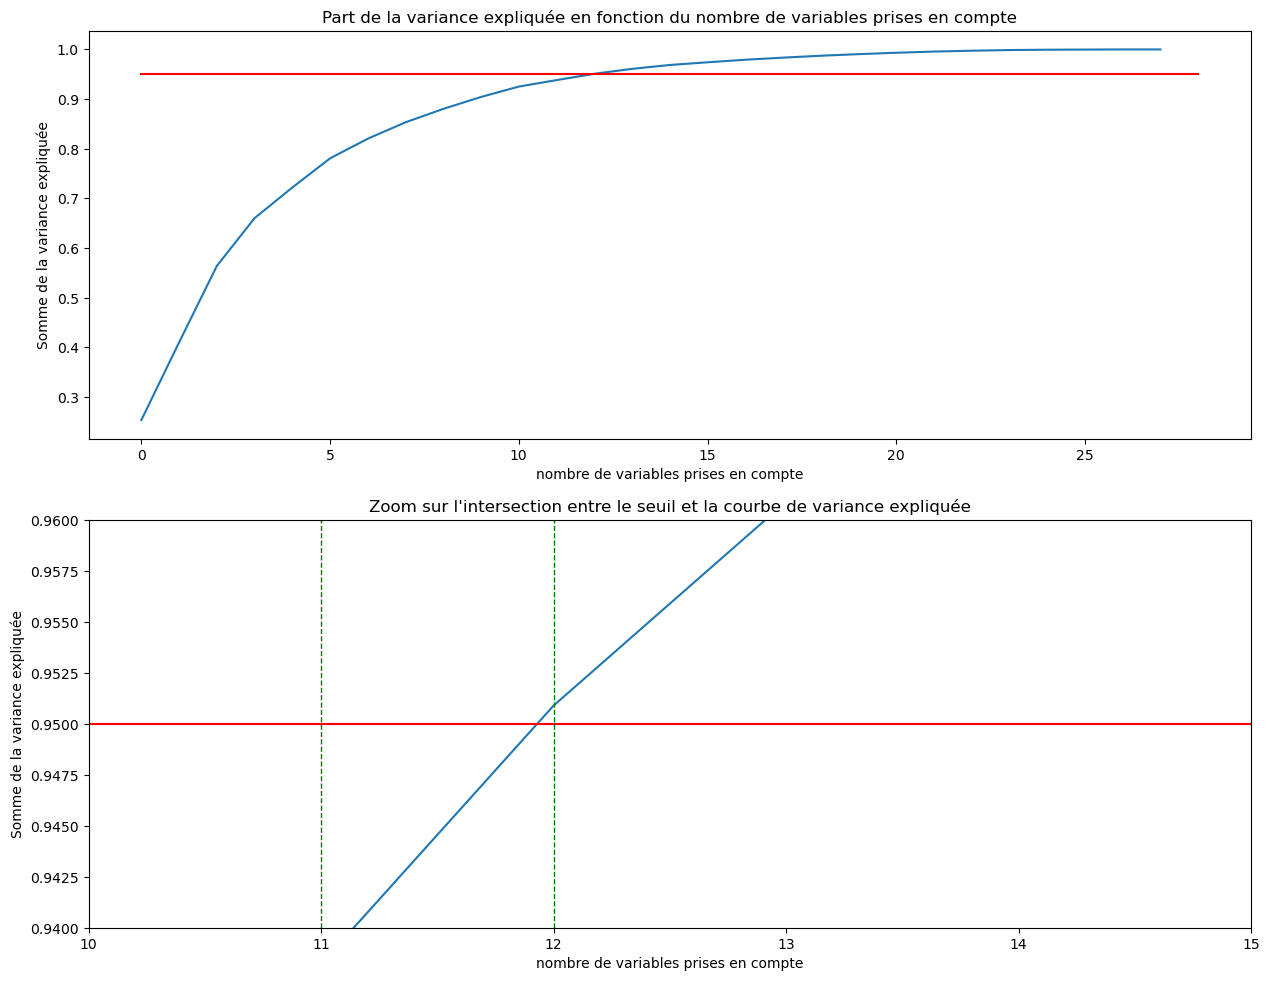

In [10]:
# selection des variables qui forment l'essentiel de la variance expliquée

from sklearn.decomposition import PCA

print(X_train_minmax.shape)

pca_n = PCA()

dn = pca_n.fit(X_train_minmax)

###############################
fig = plt.figure(figsize=(15,18))


ax1 = fig.add_subplot(311)
x = np.arange(0,len(dn.explained_variance_ratio_),1)
ax1.plot(x,np.cumsum(dn.explained_variance_ratio_[x]))
ax1.plot([0,28],[0.95,0.95],c='red')
ax1.set_ylabel("Somme de la variance expliquée")
ax1.set_xlabel("nombre de variables prises en compte")
ax1.set_title("Part de la variance expliquée en fonction du nombre de variables prises en compte")

################################
ax2 = fig.add_subplot(312)
ax2.plot(x,np.cumsum(dn.explained_variance_ratio_[x]))
ax2.plot([0,28],[0.95,0.95],c='red')
ax2.set_title("Zoom sur l'intersection entre le seuil et la courbe de variance expliquée")
ax2.set_ylabel("Somme de la variance expliquée")
ax2.set_xlabel("nombre de variables prises en compte")
ax2.plot([11,11],[0.94,0.96],color='green', marker='.', linestyle='dashed',linewidth=1, markersize=1)
ax2.plot([12,12],[0.94,0.96],color='green', marker='.', linestyle='dashed',linewidth=1, markersize=1)
ax2.set_ylim(0.94,0.96)
ax2.set_xlim(10,15)

plt.show();

In [11]:
# utilisation des fonctions prédéfinies sur la pondération des données

# fonction "weights_sqr"
def weights_sqr(d):
    inverse = 1.0 / d.astype(float)
    sqr = np.square(inverse)
    return sqr

# fonction "weights_sqr4"
def weights_sqr4(d):
    sqr2 = weights_sqr(d)
    sqr4 = np.square(sqr2)
    return sqr4

# fonction "weights_sqr8"
def weights_sqr8(d):
    sqr4 = weights_sqr4(d)
    sqr8 = np.square(sqr4)
    return sqr8

In [12]:
# utilisation d'une fonction metrique personnalisée pour prendre en compte une pondération entre les composantes

# nous utilisons ici la quantité de variance expliquée par chaque composante

print(dn.explained_variance_[0:12])

def pond_PCA(x,y):
    ma_distance =  np.abs(x-y).dot(dn.explained_variance_[0:12])
    return ma_distance

pca_optimal = PCA(n_components=12)

d_optimal = pca_optimal.fit(X_train_minmax)

X_train_minmax_pca = pca_optimal.transform(X_train_minmax)

print(X_train_minmax_pca[100,:])
x = X_train_minmax_pca[100,:]

print(X_train_minmax_pca[1000,:])
y = X_train_minmax_pca[1000,:]

print(pond_PCA(x,y))
print("\n")
print("Utilisation d'une PCA : Simulation avec 95% de la variance expliquée sur 12 composants")
print(("On utilise la distance et la pondération des meilleures simulations précédentes"))
print("\n")

pca_optimal = PCA(n_components=12)

d_optimal = pca_optimal.fit(X_train_minmax)

X_train_minmax_pca = pca_optimal.transform(X_train_minmax)
X_test_minmax_pca = pca_optimal.transform(X_test_minmax)

# Comme vu plus haut, appliquer une pondération sur la metrique de Manhattan,
# c'est la même chose qu'appliquer une pondération sur l'ensemble du jeu de données

X_train_minmax_pond_pca = X_train_minmax_pca*dn.explained_variance_[0:12]

X_test_minmax_pond_pca = X_test_minmax_pca*dn.explained_variance_[0:12]

print("dn:")
print(dn.explained_variance_[0:12])

print("X_train_minmax_pca[100,:]")
print(X_test_minmax_pca[100,:])

print("X_test_minmax_pond_pca[100,:]")
print(X_test_minmax_pond_pca[100,:])

[0.29746785 0.18348958 0.18046462 0.11295657 0.07228118 0.06885542
 0.04638181 0.03871188 0.03169033 0.02816258 0.02448213 0.01530729]
[-0.0781632   0.84141996  0.41540094 -0.5104805   0.0078397  -0.04306343
  0.05376258  0.01241435 -0.04437728 -0.04080418  0.06682409  0.00345423]
[-0.08820108  0.82212366 -0.43232758 -0.49321296 -0.00995068 -0.02699956
  0.03714615 -0.01031226  0.02918642 -0.05845229  0.10385287 -0.06188279]
0.17023954062847424


Utilisation d'une PCA : Simulation avec 95% de la variance expliquée sur 12 composants
On utilise la distance et la pondération des meilleures simulations précédentes


dn:
[0.29746785 0.18348958 0.18046462 0.11295657 0.07228118 0.06885542
 0.04638181 0.03871188 0.03169033 0.02816258 0.02448213 0.01530729]
X_train_minmax_pca[100,:]
[ 0.71331302 -0.25687929  0.20479454 -0.27657292  0.36934307  0.21946041
  0.28768672  0.07606171  0.24547042 -0.10522153  0.23386667 -0.00081826]
X_test_minmax_pond_pca[100,:]
[ 2.12187694e-01 -4.71346721e-02  3.69

In [14]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.neighbors import KNeighborsClassifier

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','pond_PCA']
# 'haversine' ==> valide seulement en 2D
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']

accuracy = []
precision = []
recall = []
f1score = []
specificity = []

CT = []

y_predict = pd.DataFrame()

temps_traitement = []
hdebut = datetime.now()
temps_traitement.append(["Début traitement",hdebut])

for i in params['nb_voisins'] :
    for dist in params['metric']:
        for w in params['weights'] :
            
            #initialisation du modèle modèle :            
            if dist == 'pond_PCA':
                if w == 'weights_sqr':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = 'manhattan', metric_params = None, n_jobs = None)
                elif w =='weights_sqr4':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = 'manhattan', metric_params = None, n_jobs = None)
                elif w =='weights_sqr8':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = 'manhattan', metric_params = None, n_jobs = None)
                else:
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = 'manhattan', metric_params = None, n_jobs = None)
                    
                knn.fit(X_train_minmax_pond_pca,y_train)
                y_p = knn.predict(X_test_minmax_pond_pca)
                y_prob = knn.predict_proba(X_test_minmax_pond_pca)
                
            else :
                if w == 'weights_sqr':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                elif w == 'weights_sqr4':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr4, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                elif w == 'weights_sqr8':
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = weights_sqr8, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                else :
                    display('calcul en cours : k='+str(i)+'--metric='+str(dist)+'--weights='+str(w),clear = True)
                    knn = KNeighborsClassifier(n_neighbors = i, weights = w, algorithm = "auto",
                                               leaf_size = 30, p = 2, metric = dist, metric_params = None, n_jobs = None)
                knn.fit(X_train_minmax_pca,y_train)
                y_p = knn.predict(X_test_minmax_pca)
                y_prob = knn.predict_proba(X_test_minmax_pca)
                
            col = 'pred'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col] = y_p
            
            col_proba = 'proba0zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,0]
            
            col_proba = 'proba1zzz'+str(i)+'zzz'+str(dist)+'zzz'+str(w)
            y_predict[col_proba] = y_prob[:,1]
                             
            ct = pd.crosstab(y_test,y_p,rownames=['Realité'],colnames=['Prédiction'])
            tp = ct.iloc[1,1]
            tn = ct.iloc[0,0]
            fp = ct.iloc[0,1]
            fn = ct.iloc[1,0]
            
            acc = Accuracy(tp,tn,fp,fn)
            pre = Precision(tp,fp)
            rec = Recall(tp,fn)
            f1s = F1score(rec,pre)
            spe = Specificity(tn,fp)
            
            CT.append([i,dist,w,tp,tn,fp,fn,acc,pre,rec,f1s,spe])
                             
            accuracy.append([i,dist,w,acc])
            precision.append([i,dist,w,pre])
            recall.append([i,dist,w,rec])
            f1score.append([i,dist,w,f1s])
            specificity.append([i,dist,w,spe])

hfin = datetime.now()

temps_traitement.append(["Fin traitement",hfin])
temps_traitement.append(["Durée traitement",hfin-hdebut])

warnings.filterwarnings("default", category=FutureWarning)

# Sauvegarde des résultats

chemin_local = 'C:/workspaces/Datascientest/MonProjetMeteo/data/'

nom_fichier = 'accuracy_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=accuracy,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'precision_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=precision,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'recall_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=recall,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'f1score_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=f1score,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'specificity_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
pd.DataFrame(data=specificity,columns=['k','metric','weights','valeur']).to_csv(nom_fichier,sep=',')

nom_fichier = 'y_predict_PCA_12c_v1.0.csv'
pd.DataFrame(data=y_predict).to_csv(nom_fichier,sep=',')

nom_fichier = 'crosstab_PCA_12c_v1.0.csv'
pd.DataFrame(data=CT,
             columns=['k','metric','weights','tp','tn','fp','fn',
                      'acc','pre','rec','f1s','spe']).to_csv(nom_fichier,sep=',')

hsav = datetime.now()
temps_traitement.append(["Fin sauvegarde",hsav])
temps_traitement.append(["Durée sauvegarde",hsav - hfin])
                         
pd.DataFrame(data=temps_traitement,columns =["Type","Valeur"]).head(10)

'calcul en cours : k=20--metric=pond_PCA--weights=weights_sqr8'

C:\Users\plebert1\AppData\Local\Temp\ipykernel_8964\3440397154.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col] = y_p
C:\Users\plebert1\AppData\Local\Temp\ipykernel_8964\3440397154.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  y_predict[col_proba] = y_prob[:,0]
C:\Users\plebert1\AppData\Local\Temp\ipykernel_8964\3440397154.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

Type                      Valeur
0  Début traitement  2023-07-16 02:21:20.859391
1    Fin traitement  2023-07-16 02:26:08.867338
2  Durée traitement              0:04:48.007947
3    Fin sauvegarde  2023-07-16 02:26:14.988339
4  Durée sauvegarde              0:00:06.121001

# Chargement des indicateurs

In [15]:
# charger les indicateurs

# from google.colab import drive
# drive.mount('/content/drive')
chemin_local = 'C:\workspaces\Datascientest\MonProjetMeteo\data\\'

# chemin_local = 'https://github.com/Mediapax/Data/raw/main/'

nom_fichier = 'accuracy_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
accuracy_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'precision_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
precision_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'recall_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
recall_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'f1score_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
f1score_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'specificity_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
specificity_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

# 611+ Mo ==> imposible de charger depuis le compte github :
# "Yowza, that’s a big file. Try again with a file smaller than 25MB."
# nom_fichier = 'y_predict_v1.0.csv'
# y_predict_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

nom_fichier = 'crosstab_PCA_12c_v1.0.csv'
path = chemin_local+nom_fichier
crosstab_v1 = pd.read_csv(nom_fichier,sep=',',index_col=0)

accuracy_v1["evaluateur"] = "accuracy_v1"
precision_v1["evaluateur"] = "precision_v1"
recall_v1["evaluateur"] = "recall_v1"
f1score_v1["evaluateur"] = "f1score_v1"
specificity_v1["evaluateur"] = "specificity_v1"

mesures = pd.concat([accuracy_v1,precision_v1,recall_v1,f1score_v1,specificity_v1])

print(accuracy_v1.head(15))
print("\n")

print(precision_v1.head(15))
print("\n")

print(recall_v1.head(15))
print("\n")

print(f1score_v1.head(15))
print("\n")

print(specificity_v1.head(15))
print("\n")

# 611+ Mo ==> imposible de charger depuis le compte github :
# "Yowza, that’s a big file. Try again with a file smaller than 25MB."
# print(y_predict_v1.head(15))
# print("\n")

print(crosstab_v1.head(15))

    k     metric       weights    valeur   evaluateur
0   1  manhattan       uniform  0.807497  accuracy_v1
1   1  manhattan      distance  0.807497  accuracy_v1
2   1  manhattan   weights_sqr  0.807497  accuracy_v1
3   1  manhattan  weights_sqr4  0.807497  accuracy_v1
4   1  manhattan  weights_sqr8  0.807497  accuracy_v1
5   1   pond_PCA       uniform  0.808966  accuracy_v1
6   1   pond_PCA      distance  0.808966  accuracy_v1
7   1   pond_PCA   weights_sqr  0.808966  accuracy_v1
8   1   pond_PCA  weights_sqr4  0.808966  accuracy_v1
9   1   pond_PCA  weights_sqr8  0.808966  accuracy_v1
10  2  manhattan       uniform  0.835705  accuracy_v1
11  2  manhattan      distance  0.807497  accuracy_v1
12  2  manhattan   weights_sqr  0.807497  accuracy_v1
13  2  manhattan  weights_sqr4  0.807497  accuracy_v1
14  2  manhattan  weights_sqr8  0.807497  accuracy_v1


    k     metric       weights   valeur    evaluateur
0   1  manhattan       uniform  0.56295  precision_v1
1   1  manhattan      dist

# Graphiques de présentation des résultats

In [16]:
print("Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins")

import warnings
from bokeh.util.warnings import BokehUserWarning
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.simplefilter(action='ignore', category=BokehUserWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)



# Code Bokeh sans utiliser de boucle : beaucoup plus rapide et zero lag.

from numpy.lib.utils import source
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool,LassoSelectTool
from bokeh.models.ranges import DataRange1d
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
from  bokeh.models import PanTool,ResetTool,HoverTool,WheelZoomTool,SaveTool,BoxZoomTool
from bokeh.models import Legend

params = {}
params['nb_voisins'] = np.arange(1,21,1)
params['metric'] = ['manhattan','pond_PCA']
# 'haversine' ==> valide seulement en 2D
params['weights'] = ['uniform','distance','weights_sqr','weights_sqr4','weights_sqr8']
    
mes_couleurs = ['magenta','maroon','mediumaquamarine','mediumblue','mediumorchid','mediumpurple','mediumseagreen',
                'mediumslateblue','mediumspringgreen','mediumturquoise','mediumvioletred','midnightblue','gold',
                'goldenrod','navy','grey','darksalmon','red']
# 9 metrics & 2 weights = 18 curves = 18 colors
# https://docs.bokeh.org/en/2.4.2/docs/reference/colors.html#bokeh-colors-named

# Attention : au moins UNE couleur de plus que le nb courbes !!!
# on utilise la couleur supplémentaire pour colorer le pt quand la souris passe dessus


source1 = ColumnDataSource(accuracy_v1)
source2 = ColumnDataSource(precision_v1)
source3 = ColumnDataSource(recall_v1)
source4 = ColumnDataSource(f1score_v1)
source5 = ColumnDataSource(specificity_v1)

tt1 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("valeur", "@valeur")]

#tools='hover,xpan,xwheel_zoom,box_zoom,save,reset'
tools=[HoverTool(),BoxZoomTool(), PanTool(),ResetTool()]

##################### Accuracy
p1 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Accuracy",
           toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur1 = []
hover1 = []
legend_item1 = []
g1 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(accuracy_v1['metric'].unique()):
    for j,w in enumerate(accuracy_v1['weights'].unique()):
        ma_source = ColumnDataSource(accuracy_v1[(accuracy_v1['metric']==dist) & (accuracy_v1['weights']==w)])
        g1.append(p1.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                           line_width=2)) #,legend_label=dist+'--'+w))
        g1.append(p1.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],
                            size=6)) #,legend_label=dist+'--'+w))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur1.append(p1.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)) #,legend_label=dist+'--'+w))

        hover1.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur1[-1]]))
        legend_item1.append((dist+'--'+w,[g1[-1],g1[-2],chgt_couleur1[-1]]))

p1.legend.visible = False
legend1 = Legend(items=legend_item1,location="center",click_policy="hide")

p1.add_layout(legend1, 'right')

tab1 = Panel(child=p1, title="Accuracy")

##################### Precision
p2 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Precision",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur2 = []
hover2 = []
legend_item2 = []
g2 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(precision_v1['metric'].unique()):
    for j,w in enumerate(precision_v1['weights'].unique()):
        ma_source = ColumnDataSource(precision_v1[(precision_v1['metric']==dist) & (precision_v1['weights']==w)])
        g2.append(p2.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g2.append(p2.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur2.append(p2.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover2.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur2[-1]]))
        legend_item2.append((dist+'--'+w,[g2[-1],g2[-2],chgt_couleur2[-1]]))

p2.legend.visible = False
legend2 = Legend(items=legend_item2,location="center",click_policy="hide")

p2.add_layout(legend2, 'right')

tab2 = Panel(child=p2, title="Precision")

# ##################### Recall
p3 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Recall",
            x_range = p1.x_range,
            toolbar_location = "below",
            tooltips = tt1,tools = tools)

chgt_couleur3 = []
hover3 = []
legend_item3 = []
g3 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(recall_v1['metric'].unique()):
    for j,w in enumerate(recall_v1['weights'].unique()):
        ma_source = ColumnDataSource(recall_v1[(recall_v1['metric']==dist) & (recall_v1['weights']==w)])
        g3.append(p3.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g3.append(p3.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur3.append(p3.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover3.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur3[-1]]))
        legend_item3.append((dist+'--'+w,[g3[-1],g3[-2],chgt_couleur3[-1]]))

p3.legend.visible = False
legend3 = Legend(items=legend_item3,location="center",click_policy="hide")

p3.add_layout(legend3, 'right')

tab3 = Panel(child=p3, title="Recall")

# ##################### F1-Score
p4 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="F1-Score",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur4 = []
hover4 = []
legend_item4 = []
g4 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(f1score_v1['metric'].unique()):
    for j,w in enumerate(f1score_v1['weights'].unique()):
        ma_source = ColumnDataSource(f1score_v1[(f1score_v1['metric']==dist) & (f1score_v1['weights']==w)])
        g4.append(p4.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g4.append(p4.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur4.append(p4.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover4.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur4[-1]]))
        legend_item4.append((dist+'--'+w,[g4[-1],g4[-2],chgt_couleur4[-1]]))

p4.legend.visible = False
legend4 = Legend(items=legend_item4,location="center",click_policy="hide")

p4.add_layout(legend4, 'right')

tab4 = Panel(child=p4, title="F1-Score")

# ##################### Specificity
p5 = figure(plot_width=800, plot_height=600,x_axis_label='k', y_axis_label='valeur',title="Specificity",
            x_range = p1.x_range,
            toolbar_location = "below",
           tooltips = tt1,tools = tools)

chgt_couleur5 = []
hover5 = []
legend_item5 = []
g5 = [] # liste des graphiques à dessiner sur la figure

for i,dist in enumerate(specificity_v1['metric'].unique()):
    for j,w in enumerate(specificity_v1['weights'].unique()):
        ma_source = ColumnDataSource(specificity_v1[(specificity_v1['metric']==dist) & (specificity_v1['weights']==w)])
        g5.append(p5.line(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],line_width=2))
        g5.append(p5.circle(x='k',y='valeur',source = ma_source,color=mes_couleurs[i+j],size=6))

        # chgt de couleur qd la souris passe sur un pt
        chgt_couleur5.append(p5.circle(x='k',y='valeur',source = ma_source,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7))

        hover5.append(HoverTool(tooltips=tt1,mode='mouse',renderers=[chgt_couleur5[-1]]))
        legend_item5.append((dist+'--'+w,[g5[-1],g5[-2],chgt_couleur5[-1]]))
        
p5.legend.visible = False
legend5 = Legend(items=legend_item5,location="center",click_policy="hide")

p5.add_layout(legend5, 'right')

tab5 = Panel(child=p5, title="Specificity")

# ##################### Accuracy en fct du F1-Score

p6 = figure(plot_width=800, plot_height=600,x_axis_label='F1-Score', y_axis_label='Accuracy',
#             title="Accuracy en fct du F1-Score",
            toolbar_location = "below",
           x_range = DataRange1d(bounds='auto'),
           y_range = DataRange1d(bounds='auto'))

acc_f1 = accuracy_v1.copy(deep=True)
acc_f1.rename(columns={'valeur':'accuracy'},inplace=True)

acc_f1['f1score'] = f1score_v1['valeur']
acc_f1['precision'] = precision_v1['valeur']
acc_f1['recall'] = recall_v1['valeur']
acc_f1['specificity'] = specificity_v1['valeur']

acc_f1['id_couleur'] = round(17 * (acc_f1['accuracy'] * acc_f1['f1score']**2),0).astype(int)
# couleurs arbitraires pour différencier :
# les meilleurs compromis F1Score/Accuracy
# les compromis moyens
# les mauvais compromis

source6 = ColumnDataSource(acc_f1)

ma_cmap = LinearColorMapper(palette=mes_couleurs, 
                             low = min(acc_f1['id_couleur']), 
                             high = max(acc_f1['id_couleur']))
            
p6.circle(x='f1score',y='accuracy',
          fill_color= {"field":"id_couleur", "transform":ma_cmap},
          line_color=None,
          source = source6,
          size=6)

# chgt de couleur qd la souris passe sur un pt
chgt_couleur6 = p6.circle(x='f1score',y='accuracy',source = source6,
                          size=15,
                          alpha=0, # alpha=0 ==> invisible tant que la souris ne va pas sur le point
                          hover_fill_color=mes_couleurs[-1], hover_alpha=0.7)

tt2 = [("k", "@k"),("metric", "@metric"),("weights","@weights"),("f1score", "@f1score"),("accuracy","@accuracy"),
      ("recall","@recall"),("precision","@precision"),("specificity","@specificity")]

hover6 = HoverTool(
        tooltips=tt2,
        mode='mouse',
        renderers=[chgt_couleur6])

p6.add_tools(hover6)

tab6 = Panel(child=p6, title="Accuracy en fct du F1-Score")

# ##################### Affichages

# h = column(row(p1,p2),row(p3,p4),row(p5,p6))
# show(h)

tabs = Tabs(tabs=[tab6,tab1,tab2,tab3,tab4,tab5])

show(tabs)

Affichage des courbes de valeur des indicateurs en fonction du nombre de voisins


# Meilleurs résultats



F1-Score : 0.611
Accuracy : 0.854
Recall : 0.524
Precision : 0.733
Specificity : 0.946
k = 9
Metric = pond_PCA
Weights =  distance


F1-Score : 0.610
Accuracy : 0.855
Recall : 0.517
Precision : 0.742
Specificity : 0.949
k = 16
Metric = pond_PCA
Weights =  weights_sqr